In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from numpy.fft import fft, ifft

In [2]:
def compute_mwt(signal, fs, peak_freq, n):
    '''
    Takes a timeseries and computes morlet wavelet convolution.
    args:
        signal(N): list, N: number of samples (time points)
        fs: int, sampling rate
        peak_freq: int, peak frequency of generated wavelet
        n: int, number of cycles in generated wavelet
    return:
        conv_result: np.ndarray, copmlex coefficients resulting from convolution
    '''

    sig = signal
    fs = fs

    # generating our wavelet
    f = peak_freq
    t = np.arange(-1, 1 + 1/fs, 1/fs)
    s = n/(2*np.pi*f)
    wavelet = np.sqrt(1/(s*np.sqrt(np.pi)))*np.exp(2*np.pi*1j*f*t) * np.exp(-t**2/((2*s)**2))

    # fft params
    n_sig = len(sig)
    n_wavelet = len(wavelet)
    n_conv = n_wavelet + n_sig - 1
    n_conv_pwr2 = 2**(math.ceil(np.log2(np.abs(n_conv))))
    n_half_wavelet = len(wavelet) // 2

    # convolultion
    sig_fft = fft(sig, n_conv_pwr2)
    wavelet_fft = fft(wavelet, n_conv_pwr2)
    conv_result = ifft(sig_fft * wavelet_fft)[:n_conv]#* (np.sqrt(s)/20) # scaling factor = np.squrt(s)/20
    conv_result = conv_result[n_half_wavelet:-n_half_wavelet]

    return conv_result

def compute_mwt_fwhm(signal, peak_freq, h_fn, fs=2000):
    '''
    Takes a timeseries and computes morlet wavelet convolution.
    args:
        signal(N): list, N: number of samples (time points)
        fs: int, sampling rate
        peak_freq: int, peak frequency of generated wavelet
        n: int, number of cycles in generated wavelet
    return:
        conv_result: np.ndarray, copmlex coefficients resulting from convolution
    '''

    sig = signal

    fs = 2000 
    f = peak_freq
    h = h_fn(f)

    f = peak_freq
    t = np.arange(-2, 2 + 1/fs, 1/fs)
    wavelet = np.exp(2*np.pi*1j*f*t) * np.exp((-4*np.log(2)*t**2)/h**2)

    # fft params
    n_sig = len(sig)
    n_wavelet = len(wavelet)
    n_conv = n_wavelet + n_sig - 1
    n_conv_pwr2 = 2**(math.ceil(np.log2(np.abs(n_conv))))
    n_half_wavelet = len(wavelet) // 2

    # convolultion
    sig_fft = fft(sig, n_conv_pwr2)
    wavelet_fft = fft(wavelet, n_conv_pwr2)
    conv_result = ifft(sig_fft * wavelet_fft)[:n_conv]#* (np.sqrt(s)/20) # scaling factor = np.squrt(s)/20
    conv_result = conv_result[n_half_wavelet:-n_half_wavelet]

    return conv_result

def baseline_norm(raw_pwr, bline_index, db=False):
    '''
    takes n by m matrix of raw power and normalizes each frequency to baseline period
    defined by bline_index. if db is False, norm is computed by dividing each sample by the
    mean of the baseline period. is db is True, computes decibel norm instead.
    raw_pwr a list of lists; each sublist is instantaneous power over time (samples)
    for a given frequency in freq range of mwt.
    bline_index denotes the the index at which the baseline period ends and the
    signal begins.

    args:
        raw_pwr(t,N): np.ndarray, t: number of trials, N: number of samples
        bline_index: int, denotes index where trial begins and baseline ends
    return:
        norm_pwr: np.npdarray(t,N-bline_index), note section of data considered
            as baseline is not returned
    '''
    norm_pwr = []
    for f_sig in raw_pwr:

        sig = f_sig[bline_index:]
        baseline = f_sig[:bline_index]
        b_mean = np.average(baseline)

        if not db:
            norm_sig = np.array(sig) / b_mean
        elif db:
            norm_sig = 10 * np.log10(sig / b_mean)

        norm_pwr.append(norm_sig)

    return norm_pwr

def plot_spectrogram(norm_avg, t_zero, freqs, label):
    f, ax = plt.subplots(1,1)
    f.set_figheight(4)
    f.set_figwidth(7)

    fs = 2000
    time = np.arange((0-t_zero) / fs, (np.shape(norm_avg)[1] - t_zero) / fs, 1/fs)
    title = ' '.join(label.split('_'))

    n = 50
    vmin = np.min(norm_avg)    #================== harded coded params =================#
    vmax = np.max(norm_avg)
    levels = np.linspace(vmin, vmax, n+1)

    # plot contour fill
    cs = ax.contourf(time, freqs, norm_avg, levels=levels, cmap='magma')
    ax.set_title(title, size=16)
    ax.set_xlabel('Time (ms), press @ t=0', fontsize=16)
    ax.set_ylabel('Frequency (Hz)', fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    # add color bar
    cb = f.colorbar(cs, ax=ax, shrink=0.9, ticks=np.linspace(vmin,vmax, 7))
    cb.ax.tick_params(labelsize=16)
    cb.ax.set_yticklabels(np.round(np.linspace(0,vmax, 7),1))

    frange = f'{freqs.min()}-{freqs.max()} Hz'

os.listdir('../curation/data_curated/CUE1_lte2400')

['Vehicle_coke_PFC_curated.npy',
 'ChABC_coke_HPC_curated.npy',
 'ChABC_saline_PFC_curated.npy',
 'Vehicle_saline_PFC_curated.npy',
 'ChABC_saline_HPC_curated.npy',
 'Vehicle_saline_HPC_curated.npy',
 'ChABC_coke_PFC_curated.npy',
 'Vehicle_coke_HPC_curated.npy']

In [3]:
data = np.load('../curation/data_curated/CUE1_lte2400/Vehicle_coke_PFC_curated.npy', allow_pickle=True).item()
signal = data['Ephys11_rat1_trial2']
signals = list(data.values())

freqs = np.arange(1,101)
h_dict =dict(zip(freqs, np.linspace(800,200,len(freqs))))

raw_pwr = []
for signal in signals:
    s = []
    for f in freqs:
        # analytic_sig = compute_mwt_fwhm(signal, f, h_fn=lambda f: h_dict[f]/1000)
        # analytic_sig = compute_mwt_fwhm(signal, f, h_fn= lambda f: 3200/(10*np.log(f))/1000)
        # analytic_sig = compute_mwt_fwhm(signal, f, h_fn= lambda f: 3200/(10*np.log(f))/1000)
        analytic_sig = compute_mwt_fwhm(signal, f, h_fn= lambda f: 3200/(2*f**(1/2))/1000)
        s.append(analytic_sig)
    raw_pwr.append(np.array(abs(np.array(s))**2))

norm_pwr = []
for trial in raw_pwr:
    norm = baseline_norm(trial, 1500)
    norm_pwr.append(norm)

norm_avg = np.average(np.array(norm_pwr), axis=0)

f, ax = plt.subplots(1,1)
f.set_figheight(4)
f.set_figwidth(7)
cs = ax.contourf(np.arange(-500,1999), freqs, norm_avg, levels=40, cmap='magma')
plt.show()

##### 

norm_pwr = []
for trial in raw_pwr:
    norm = baseline_norm(trial.T[500:].T, 1000)
    norm_pwr.append(norm)

norm_avg = np.average(np.array(norm_pwr), axis=0)

f, ax = plt.subplots(1,1)
f.set_figheight(4)
f.set_figwidth(7)
cs = ax.contourf(np.arange(-500,1999), freqs, norm_avg, levels=40, cmap='magma')
plt.show()

# norm = baseline_norm(s.T[500:].T, 1000)
# f, ax = plt.subplots(1,1)
# f.set_figheight(4)
# f.set_figwidth(7)
# cs = ax.contourf(np.arange(-500,1999), freqs, norm, levels=40, cmap='magma')
# plt.show()

KeyboardInterrupt: 

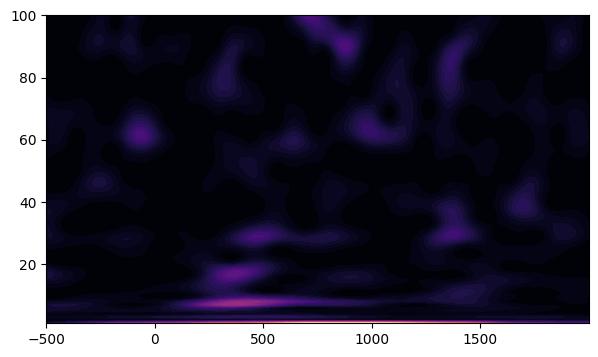

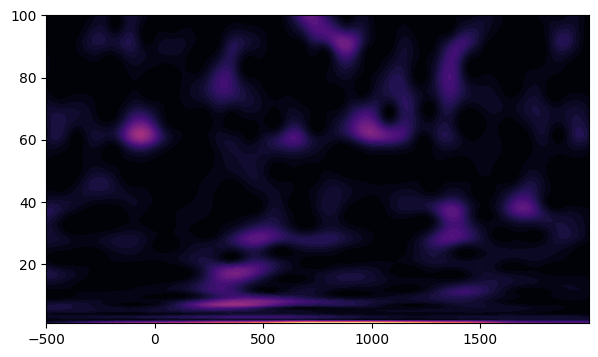

In [ ]:
freqs = np.arange(1,101)
ns = np.linspace(3,12, len(freqs))  
n_dict = dict(zip(freqs, ns))

s = []
for f in freqs:
    analytic_sig = compute_mwt(signal, fs=2000, peak_freq=f, n=n_dict[f])
    s.append(analytic_sig)

s = np.array(abs(np.array(s)) ** 2)
norm = baseline_norm(s, 1500)
f, ax = plt.subplots(1,1)
f.set_figheight(4)
f.set_figwidth(7)
cs = ax.contourf(np.arange(-500,2000), freqs, norm, levels=40, cmap='magma')
plt.show()

norm = baseline_norm(s.T[500:].T, 1000)
f, ax = plt.subplots(1,1)
f.set_figheight(4)
f.set_figwidth(7)
cs = ax.contourf(np.arange(-500,2000), freqs, norm, levels=40, cmap='magma')
plt.show()